<a href="https://colab.research.google.com/github/xilingzou/DataAnalytics/blob/main/CIS530%20hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from multiprocessing import Pool
import numpy as np
import time
from utils import *
import pandas as pd
import seaborn as sn


""" Contains the part of speech tagger class. """


def evaluate(data, model, method, smoothing = None, beam_width = 1):
    """Evaluates the POS model on some sentences and gold tags.

    This model can compute a few different accuracies:
        - whole-sentence accuracy
        - per-token accuracy
        - compare the probabilities computed by different styles of decoding

    You might want to refactor this into several different evaluation functions,
    or you can use it as is. 
    
    As per the write-up, you may find it faster to use multiprocessing (code included). 
    
    """
    print("method =", method)
    print("smoothing =", smoothing)
    print("beam_width =", beam_width)
    processes = 4
    sentences = data[0]
    tags = data[1]
    n = len(sentences)
    k = n//processes
    n_tokens = sum([len(d) for d in sentences])
    unk_n_tokens = sum([1 for s in sentences for w in s if w not in model.word2idx.keys()])
         
    start = time.time()
    predictions = []
    probabilities = []
    for i in range(n):
      #predictions.append(model.trigram_viterbi(sentences[i], False))
      predictions.append(model.inference(sentences[i], method, smoothing, beam_width))
    print(f"Inference Runtime: {(time.time()-start)/60} minutes.")
    
    start = time.time()
    method_list = method.split("_")
    f = None
    if "bigram" in method_list:
      f = model.fst_ord_sequence_probability
    else:
      f = model.snd_ord_sequence_probability
    for i in range(n):
      probabilities.append(f(sentences[i], tags[i]))
    print(f"Probability Estimation Runtime: {(time.time()-start)/60} minutes.")


    token_acc = sum([1 for i in range(n) for j in range(len(sentences[i])) if tags[i][j] == predictions[i][j]]) / n_tokens
    unk_token_acc = sum([1 for i in range(n) for j in range(len(sentences[i])) if tags[i][j] == predictions[i][j] and sentences[i][j] not in model.word2idx.keys()]) / unk_n_tokens
    whole_sent_acc = 0
    num_whole_sent = 0
    for k in range(n):
        sent = sentences[k]
        eos_idxes = indices(sent, '.')
        start_idx = 1
        end_idx = eos_idxes[0]
        for i in range(1, len(eos_idxes)):
            whole_sent_acc += 1 if tags[k][start_idx:end_idx] == predictions[k][start_idx:end_idx] else 0
            num_whole_sent += 1
            start_idx = end_idx+1
            end_idx = eos_idxes[i]
    print("Whole sent acc: {}".format(whole_sent_acc/num_whole_sent))
    print("Mean Probabilities: {}".format(sum(probabilities)/n))
    print("Token acc: {}".format(token_acc))
    print("Unk token acc: {}".format(unk_token_acc))
    
    confusion_matrix(model.tag2idx, model.idx2tag, predictions, tags, 'cm.png')

    return whole_sent_acc/num_whole_sent, token_acc, sum(probabilities)/n


class POSTagger():
    def __init__(self):
        """Initializes the tagger model parameters and anything else necessary. """
        self.data = None
        self.all_tags = None
        self.tag2idx = None
        self.idx2tag = None
        self.tag_num = None
        self.all_words = None
        self.word2idx = None
        self.idx2word = None
        self.words_num = None
        self.n = None
        self.word_tag_list = None
        self.START_WORD = '-docstart-'
        self.START_TAG = 'O'
        self.k = 0.1
        pass
    
    
    def get_unigrams(self):
        """
        Computes unigrams. 
        Tip. Map each tag to an integer and store the unigrams in a numpy array. 
        """
        ## TODO
        unigram = {}
        unigram_c = {}
        tag_list = list([t for tag in self.data[1] for t in tag])
        self.n = len(tag_list)
        values, counts = np.unique(tag_list, return_counts=True)
        for v, c in zip(values, counts):
            unigram_c[v] = c
            unigram[v] = np.log(c) - np.log(self.n)
        return unigram_c, unigram

    def get_bigrams(self):        
        """
        Computes bigrams. 
        Tip. Map each tag to an integer and store the bigrams in a numpy array
             such that bigrams[index[tag1], index[tag2]] = Prob(tag2|tag1). 
        """
        ## TODO
        unigram_c, unigram = self.get_unigrams()
        bigram = {}
        bigram_c = {}
        bitags = [tuple((['O'] + tag)[i:i + 2]) for tag in self.data[1] for i in range(len(tag)) if len((['O'] + tag)[i:i + 2]) == 2]
        values, counts = np.unique(bitags, return_counts=True, axis=0)
        for [t1, t2], c in zip(values, counts):
            #bigram[(t1, t2)] = np.log(c) - (unigram.get(t1, 0) + np.log(self.n))
            bigram[(t1, t2)] = np.log(c) - np.log(unigram_c.get(t1, 0))
            bigram_c[(t1, t2)] = c
        return bigram_c, bigram
    
    def get_trigrams(self):
        """
        Computes trigrams. 
        Tip. Similar logic to unigrams and bigrams. Store in numpy array. 
        """
        ## TODO
        _, unigram = self.get_unigrams()
        bigram_c, bigram = self.get_bigrams()
        trigram = {}
        trigram_c = {}
        tritags = [tuple((['O'] + tag)[i:i + 3]) for tag in self.data[1] for i in range(len(tag) + 1) if
                   len((['O'] + tag)[i:i + 3]) == 3]
        values, counts = np.unique(tritags, return_counts=True, axis=0)
        for [t1, t2, t3], c in zip(values, counts):
            trigram_c[(t1, t2, t3)] = c
            #trigram[(t1, t2, t3)] = \
            #np.log(c) - (bigram.get((t1, t2), 0) + unigram.get(t1, 0) + np.log(self.n))
            trigram[(t1, t2, t3)] = np.log(c) - np.log(bigram_c.get((t1, t2), 0))
        return trigram_c, trigram
    
    
    def get_emissions(self):
        """
        Computes emission probabilities. 
        Tip. Map each tag to an integer and each word in the vocabulary to an integer. 
             Then create a numpy array such that lexical[index(tag), index(word)] = Prob(word|tag) 
        """
        ## TODO
        emission = {}
        tag_list = list([t for tag in self.data[1] for t in tag])
        word_list = list([w for words in self.data[0] for w in words])
        tag_word = list(zip(tag_list, word_list))
        values, counts = np.unique(tag_word, return_counts=True, axis=0)
        for [t, w], c in zip(values, counts):
            emission[(t, w)] = np.log(c) - (np.log(self.unigrams.get(t, 0)) + np.log(self.n))

        return emission

    def get_laplace_unigrams(self, k = 0.05):
      laplace_unigrams = {}
      unigram_c, _ = self.get_unigrams()
      for t in unigram_c:
        laplace_unigrams[t] = np.e**(np.log(unigram_c[t]+k)-np.log(self.n+k*self.tag_num))
      return laplace_unigrams


    def get_laplace_bigrams(self, k = 0.05):
      laplace_bigrams = {}
      unigram_c, _ = self.get_unigrams()
      bigram_c, _ = self.get_bigrams()
      for t in bigram_c:
        t1, t2 = t
        laplace_bigrams[t] = np.e**(np.log(bigram_c[t]+k)-np.log(unigram_c.get(t1, 0)+k*self.tag_num))
      return laplace_bigrams


    def get_laplace_trigrams(self, k = 0.05):
      laplace_trigrams = {}
      unigram_c, _ = self.get_unigrams()
      bigram_c, _ = self.get_bigrams()
      trigram_c, _ = self.get_trigrams()
      for t in trigram_c:
        t1, t2, t3 = t
        laplace_trigrams[t] = np.e**(np.log(trigram_c[t]+k)-np.log(bigram_c.get((t1, t2), 0)+k*self.tag_num))
      return laplace_trigrams

    
    def get_suffix_matrix(self):
      suffix_matrix = {}
      sentences = self.data[0]
      tags = self.data[1]
      for sequence, tag in zip(sentences, tags):
        for w, t in zip(sequence, tag):
          w_n = len(w)
          for i in range(1,6):
            if w_n >= i:
              if w[-i:] in suffix_matrix:
                if t in suffix_matrix[w[-i:]]:
                  suffix_matrix[w[-i:]][t] += 1
                else:
                  suffix_matrix[w[-i:]][t] = 1
              else:
                suffix_matrix[w[-i:]] = {}
                suffix_matrix[w[-i:]][t] = 1
      return suffix_matrix
    
    def unknown_word(self, w):
      w_n = len(w)
      frequency_count = None
      emissions = {}
      word_tag_list = {}
      for i in range(5,0, -1):
        if w_n >= i:
          suffix = w[-i:]
          if suffix in self.suffix_matrix:
            frequency_count = self.suffix_matrix[suffix]
            break
      if not frequency_count:
        self.emissions[('NN', w)] = 1
        self.word_tag_list[w] = set(['NN'])
        emissions[('NN', w)] = 1
        word_tag_list[w] = set(['NN'])
        return emissions, word_tag_list
      
      self.word_tag_list[w] = set([])
      word_tag_list[w] = set([])
      for t in frequency_count:
        self.word_tag_list[w].add(t)
        word_tag_list[w].add(t)

        emissions[(t, w)] = frequency_count[t]/self.unigram_c[t]
        self.emissions[(t, w)] = frequency_count[t]/self.unigram_c[t]
      
      return emissions, word_tag_list


    def train(self, data):
        """Trains the model by computing transition and emission probabilities.

        You should also experiment:
            - smoothing.
            - N-gram models with varying N.
        
        """
        self.data = data
        self.n = len([w for words in self.data[0] for w in words])
        self.all_tags = list(set([t for tag in data[1] for t in tag]))
        self.tag_num = len(self.all_tags)
        self.tag2idx = {self.all_tags[i]:i for i in range(len(self.all_tags))}
        self.idx2tag = {v:k for k,v in self.tag2idx.items()}
        ## TODO
        self.all_words = list(set([w for words in self.data[0] for w in words]))
        self.words_num = len(self.all_words)
        self.word2idx = {self.all_words[i]:i for i in range(len(self.all_words))}
        self.idx2word = {v:k for k,v in self.word2idx.items()}  

        tag_list = [t for tag in self.data[1] for t in tag]
        word_list = [w for words in self.data[0] for w in words]
        tag_word = list(zip(tag_list, word_list))
        word_tag_list = {}
        for tag, word in tag_word:
          if word in word_tag_list:
            word_tag_list[word].add(tag)
          else:
            word_tag_list[word] = set()
            word_tag_list[word].add(tag)
        self.word_tag_list = word_tag_list
        self.suffix_matrix = self.get_suffix_matrix()
        
        self.unigram_c, self.log_unigrams = self.get_unigrams()
        self.bigram_c, self.log_bigrams = self.get_bigrams()
        self.trigram_c, log_trigrams = self.get_trigrams()
        # interpolation
        weights = deleted_interpolation(self.unigram_c, self.bigram_c, self.trigram_c)
        self.unigrams = {a: np.exp(self.log_unigrams[a]) for a in self.log_unigrams}
        self.bigrams = {(a, b): np.exp(self.log_bigrams[(a, b)]) for a, b in self.log_bigrams}
        # original trigrams
        self.trigrams = {(a, b, c): np.exp(log_trigrams[(a, b, c)]) for a, b, c in log_trigrams}
        # trigrams with interpolation
        self.itpl_trigrams = {(a, b, c): weights[2]*np.exp(log_trigrams[(a, b, c)])+
                         weights[1]*self.bigrams.get((a, b), 0)+
                         weights[0]*self.unigrams.get(a, 0) for a, b, c in log_trigrams}
        
        self.log_emissions = self.get_emissions()
        self.emissions = {(t, w): np.exp(self.log_emissions[(t, w)]) for t, w in self.log_emissions}

        self.laplace_unigram = self.get_laplace_unigrams(self.k)
        self.laplace_bigrams = self.get_laplace_bigrams(self.k)
        self.laplace_trigrams = self.get_laplace_trigrams(self.k)


    def sequence_probability(self, sequence, tags):
        """Computes the probability of a tagged sequence given the emission/transition
        probabilities.
        """
        ## TODO
        #n = len(sequence)
        #seq_prob = 1.0
        # tag[0]: START, tag[n-1]: STOP
        #for i in range(1, n):
        #    q = self.bigrams.get((tags[i-1], tags[i]), 0)
        #    seq_prob *= q
        #    if i < n-1:
        #        e = self.emissions.get((tags[i], sequence[i]), 0)
        #        seq_prob *= e
        #return seq_prob
        return np.e**(self.snd_ord_sequence_probability(sequence, tags))

    def fst_ord_sequence_probability(self, sequence, tags):

      """Computes the probability of a tagged sequence given the emission/transition
      probabilities. First order Markov model (bigrams as transition).
      """
        ## TODO
      n = len(sequence)
      # tag[0]: START, tag[n-1]: STOP
      log_seq_prob = 0
      for i in range(1, n):
          log_q = self.log_bigrams.get((tags[i - 1], tags[i]), -100)
          log_seq_prob += log_q
          if i < n - 1:
              log_e = self.log_emissions.get((tags[i], sequence[i]), -100)
              log_seq_prob += log_e
      return log_seq_prob

    def snd_ord_sequence_probability(self, sequence, tags):
        """
        Second order Markov model (trigrams as transition)
        """
        n = len(sequence)
        log_seq_prob = 0
        for i in range(2, n):
            log_q = np.log(self.trigrams.get((tags[i - 2], tags[i - 1], tags[i]), np.e**-100))
            log_seq_prob += log_q
            if i < n-1:
                log_e = self.log_emissions.get((tags[i], sequence[i]), -100)
                log_seq_prob += log_e
        return log_seq_prob

    def inference(self, sequence, method, smoothing = None, beam_width=1):
        """Tags a sequence with part of speech tags.

        You should implement different kinds of inference (suggested as separate
        methods):

            - greedy decoding
            - decoding with beam search
            - viterbi
        """
        ## TODO
        if method == "bigram_beam_search":
          return self.bigram_beam_search(sequence, smoothing, beam_width)
        elif method == "trigram_beam_search":
          return self.trigram_beam_search(sequence, smoothing, beam_width)
        elif method == "bigram_greedy":
          return self.bigram_beam_search(sequence, smoothing, 1)
        elif method == "trigram_greedy":
          return self.trigram_beam_search(sequence, smoothing, 1)
        elif method == "bigram_viterbi":
          return self.bigram_viterbi(sequence, smoothing)
        elif method == "trigram_viterbi":
          return self.trigram_viterbi(sequence, smoothing)
        return []

    def bigram_beam_search(self, sequence, smoothing, beam_width):
      emissions = self.emissions
      bigrams = self.bigrams
      beam_score = {}
      if smoothing:
        bigrams = self.laplace_bigrams
      for j in range(1, len(sequence)):
          new_score = {}
          word = sequence[j]
          if word not in self.word2idx:
            self.unknown_word(word)
            emissions = self.emissions
          for tag_i in self.word_tag_list[word]:
              e = np.log(emissions.get((tag_i, word), np.e ** -100))
              if j == 1:
                  p = np.log(bigrams.get((self.START_TAG, tag_i), np.e ** -100))
                  new_score[(self.START_TAG, tag_i)] = e + p
              else:
                  for seq in list(candidates.keys()):
                      tag_j = seq[-1]
                      p = np.log(bigrams.get((tag_j, tag_i), np.e ** -100))
                      seq_lst = list(seq)
                      seq_lst.append(tag_i)
                      new_seq = tuple(seq_lst)
                      new_score[new_seq] = beam_score.get(seq, float('-inf')) + p + e

          beam_score = new_score.copy()
          # keep only k sequences as candidates
          k = min(len(beam_score.keys()), beam_width)
          candidates = {k: v for k, v in sorted(beam_score.items(), key=lambda item: item[1],
                                                reverse=True)[:k]}

      pred = list(list(candidates.keys())[0])
      return pred

    def trigram_beam_search(self, sequence, smoothing, beam_width):
      emissions = self.emissions
      trigrams = self.trigrams
      if smoothing == 'interpolation':
        trigrams = self.itpl_trigrams
      elif smoothing == 'laplace':
        trigrams = self.laplace_trigrams
      beam_score = {}
      sequence = [self.START_WORD] + sequence

      for j in range(1, len(sequence)):
          new_score = {}
          word = sequence[j]
          if word not in self.word2idx:
            self.unknown_word(word)
            emissions = self.emissions
          for tag_i in self.word_tag_list[word]:
              e = np.log(emissions.get((tag_i, word), np.e ** -100))
              if j == 1:
                  p = np.log(trigrams.get((self.START_TAG, self.START_TAG, tag_i), np.e ** -100))
                  new_score[(self.START_TAG, tag_i)] = e + p
              else:
                  for seq in list(candidates.keys()):
                      tag_k = seq[-2]
                      tag_j = seq[-1]
                      p = np.log(trigrams.get((tag_k, tag_j, tag_i), np.e ** -100))
                      seq_lst = list(seq)
                      seq_lst.append(tag_i)
                      new_seq = tuple(seq_lst)
                      new_score[new_seq] = beam_score.get(seq, float('-inf')) + p + e

          beam_score = new_score.copy()
          # keep only k sequences as candidates
          k = min(len(beam_score.keys()), beam_width)
          candidates = {k: v for k, v in sorted(beam_score.items(), key=lambda item: item[1],
                                                reverse=True)[:k]}

      pred = list(list(candidates.keys())[0][1:])
      return pred   

    def bigram_viterbi(self, sequence, smoothing):
      emissions = self.emissions
      bigrams = self.bigrams
      if smoothing == "laplace":
        bigrams = self.laplace_bigrams
      pi = {}
      bp = {}
      max_score = float('-inf')
      max_tag_tuple = None
      for j in range(len(sequence)):  
        word = sequence[j]
        if word not in self.word2idx:
          self.unknown_word(word)
          emissions = self.emissions
        for tag_i in self.word_tag_list[word]:
          e = np.log(emissions.get((tag_i, word),np.e**-100))
          if j == 0:
            p = np.log(bigrams.get((self.START_TAG, tag_i), np.e**-100))
            pi[(self.START_TAG, j)] = e + p
            bp[(self.START_TAG, j)] = self.START_TAG
          else:
            max_score = float('-inf')
            max_tag = None
            for tag_j in self.word_tag_list[sequence[j-1]]:
              p = np.log(bigrams.get((tag_j, tag_i), np.e**-100))
              score = pi.get((tag_j, j - 1), -100) + p + e
              if score > max_score:
                max_score = score
                max_tag = tag_j
              
              pi[(tag_i , j)] = max_score
              bp[(tag_i , j)] = max_tag
      backtrack = [tag_i]
      pred = [tag_i]
      for idx, word in list(enumerate(sequence))[len(sequence)-2::-1]:
        tag_j = bp[(backtrack[-1], idx + 1)]
        backtrack.append(tag_j)
        pred.append(tag_j)
      
      return pred[::-1]

    def deleted_trigram_viterbi(self, sequence, smoothing):
      emissions = self.emissions
      trigrams = self.trigrams
      if smoothing == 'interpolation':
        trigrams = self.itpl_trigrams
      elif smoothing == 'laplace':
        trigrams = self.laplace_trigrams
      pi = {}
      bp = {}
      sequence = [self.START_WORD] + sequence
      max_score = float('-inf')
      max_tag_tuple = None
      for j in range(2, len(sequence)):  
        word = sequence[j]
        if word not in self.word2idx:
          self.unknown_word(word)
          emissions = self.emissions
        for tag_i in self.word_tag_list[word]:
          e = np.log(emissions.get((tag_i, word),np.e**-100))
          if j == 2:
            p = np.log(trigrams.get((self.START_TAG, self.START_TAG, tag_i), np.e**-100))
            pi[((self.START_TAG, tag_i), j)] = e + p
            bp[((self.START_TAG, tag_i), j)] = (self.START_TAG, self.START_TAG)
          else:
            max_score = float('-inf')
            max_tag_tuple = None
            for tag_j in self.word_tag_list[sequence[j-1]]:
              for tag_k in self.word_tag_list[sequence[j-2]]:
                p = np.log(trigrams.get((tag_k, tag_j, tag_i), np.e**-100))
                score = pi.get(((tag_k, tag_j), j - 1), -100) + p + e
                if score > max_score:
                  max_score = score
                  max_tag_tuple = (tag_k, tag_j)
              
              pi[((tag_j, tag_i) , j)] = max_score
              bp[((tag_j, tag_i) , j)] = max_tag_tuple

      backtrack = [(max_tag_tuple[1], tag_i)]
      pred = [tag_i]
      for idx, word in list(enumerate(sequence))[len(sequence)-2:0:-1]:
        tag_j, tag_i = bp[(backtrack[-1], idx + 1)]
        backtrack.append((tag_j, tag_i))
        pred.append(tag_i)
      
      return pred[len(pred)-1::-1]
    
    def trigram_viterbi(self, sequence, smoothing):
      emission = self.emissions
      trigrams = self.trigrams
      if smoothing == 'interpolation':
        trigrams = self.itpl_trigrams
      elif smoothing == 'laplace':
        trigrams = self.laplace_trigrams
      pi = {}
      bp = {}

      pi[(0, self.START_TAG, self.START_TAG)] = 0

      n = len(sequence)
      max_score = float('-Inf')
      u_last, v_last = None, None
      for k in range(1, n+1):
        word = sequence[k-1]
        if word not in self.word2idx:
            self.unknown_word(word)
            emissions = self.emissions
        if  k-1 <= 0:
          tag_list = {self.START_TAG}
        else:
          tag_list = self.word_tag_list[sequence[k-2]]
        for u in tag_list:
          for v in self.word_tag_list[word]:
            max_score = float('-Inf')
            max_tag = None
            if  k-2 <= 0:
              tag_list = {self.START_TAG}
            else:
              tag_list = self.word_tag_list[sequence[k-3]]
            for w in tag_list:
              e = np.log(emission.get((v, word), np.e**-100))
              q = np.log(trigrams.get((w, u, v), np.e**-100))
              score = pi.get((k-1, w, u), -100) + q + e
              if score > max_score:
                max_score = score
                max_tag = w
                u_last = u
                v_last = v
            pi[(k, u, v)] = max_score
            bp[(k, u, v)] = max_tag


      pred = [v_last, u_last]

      for k in range(n, 2, -1):
          pred.append(bp[(k, pred[-1], pred[-2])])
      return pred[::-1]



def deleted_interpolation(unigram_c, bigram_c, trigram_c):
    lambda1 = 0
    lambda2 = 0
    lambda3 = 0
    for a, b, c in trigram_c.keys():
        v = trigram_c[(a, b, c)]
        if v > 0:
            c1 = (v - 1) / (bigram_c.get((a, b), 0) - 1)
            c2 = (bigram_c.get((a, b), 0) -1) / (unigram_c.get(a, 0) - 1)
            c3 = (unigram_c.get(a, 0) - 1) / (sum(unigram_c.values()) - 1)
            clist = [c1, c2, c3]
            m = np.argmax(clist)
            if m == 0:
                lambda1 += v
            if m == 1:
                lambda2 += v
            if m == 2:
                lambda3 += v

    weights = [lambda1, lambda2, lambda3]
    weights = [a / sum(weights) for a in weights]
    return weights

if __name__ == "__main__":
    pos_tagger = POSTagger()

    train_data = load_data("data/train_x.csv", "data/train_y.csv")
    dev_data = load_data("data/dev_x.csv", "data/dev_y.csv")
    test_data = load_data("data/test_x.csv")

    pos_tagger.train(train_data)

    # Experiment with your decoder using greedy decoding, beam search, viterbi...

    # Here you can also implement experiments that compare different styles of decoding,
    # smoothing, n-grams, etc.
    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "trigram_viterbi", None)
    
    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "bigram_viterbi", None)

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "trigram_viterbi", "interpolation")
    
    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "bigram_viterbi", "interpolation")

    #print("--------------------")
    evaluate(dev_data, pos_tagger, "trigram_viterbi", "laplace")
    
    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "bigram_viterbi", "laplace")

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "trigram_greedy", "interpolation")
    
    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "bigram_greedy", "interpolation")

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "trigram_greedy", "laplace")
    
    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "bigram_greedy", "laplace")

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "trigram_greedy", None)
    
    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "bigram_greedy", None)

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "bigram_beam_search", "interpolation", beam_width = 5)

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "trigram_beam_search", "interpolation", beam_width = 5)

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "bigram_beam_search", "laplace", beam_width = 5)

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "trigram_beam_search", "laplace", beam_width = 5)

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "bigram_beam_search", beam_width = 5)

    #print("--------------------")
    #evaluate(dev_data, pos_tagger, "trigram_beam_search", beam_width = 5)

    # Predict tags for the test set
    # Write them to a file to update the leaderboard
    # TODO

    result = []
    for sequence in test_data:
      result.append(pos_tagger.trigram_viterbi(sequence, "laplace"))
    output = [t for tags in result for t in tags if t != "<STOP>"]
    df = pd.DataFrame(output)
    df.columns = ['tag']
    df.index.name = 'id'
    df.to_csv('test_y.csv')



100%|██████████| 463/463 [00:01<00:00, 372.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:601: RuntimeWarning: invalid value encountered in long_scalars


method = trigram_viterbi
smoothing = laplace
beam_width = 1
Inference Runtime: 0.2565836548805237 minutes.
Probability Estimation Runtime: 0.013339789708455403 minutes.
Whole sent acc: 0.39471189297377013
Mean Probabilities: -5754.965447055896
Token acc: 0.9549948045654112
Unk token acc: 0.7296350694836742


NameError: ignored

<Figure size 720x504 with 0 Axes>

In [ ]:
from google.colab import files 

files.download("test_y.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------
method = trigram_beam_search
smoothing = laplace
beam_width = 2
Inference Runtime: 0.24040358066558837 minutes.
Probability Estimation Runtime: 0.01388190189997355 minutes.
Whole sent acc: 0.3571052354366375
Mean Probabilities: -5754.965447055896
Token acc: 0.9496761580890658
Unk token acc: 0.7048921025872783
--------------------
method = trigram_beam_search
smoothing = laplace
beam_width = 3
Inference Runtime: 0.3586875557899475 minutes.
Probability Estimation Runtime: 0.0137346347173055 minutes.
Whole sent acc: 0.3845991783419362
Mean Probabilities: -5754.965447055896
Token acc: 0.9533150158327276
Unk token acc: 0.7161902609874591
--------------------
method = trigram_beam_search
smoothing = laplace
beam_width = 5
Inference Runtime: 0.527727234363556 minutes.
Probability Estimation Runtime: 0.013643344243367514 minutes.
Whole sent acc: 0.3924997366480565
Mean Probabilities: -5754.965447055896
Token acc: 0.9545964194625497
Unk token acc: 0.7209354875155349


(0.3924997366480565, 0.9545964194625497, -5754.965447055896)

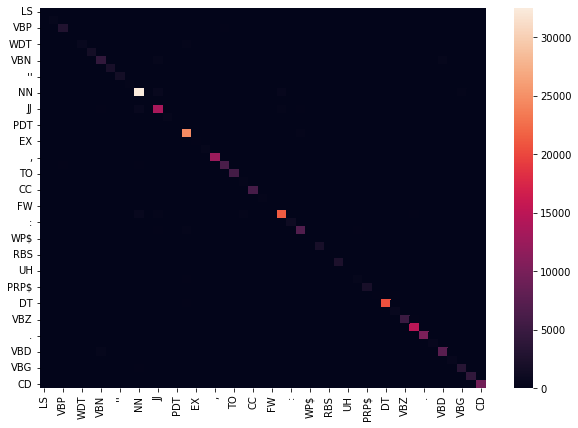

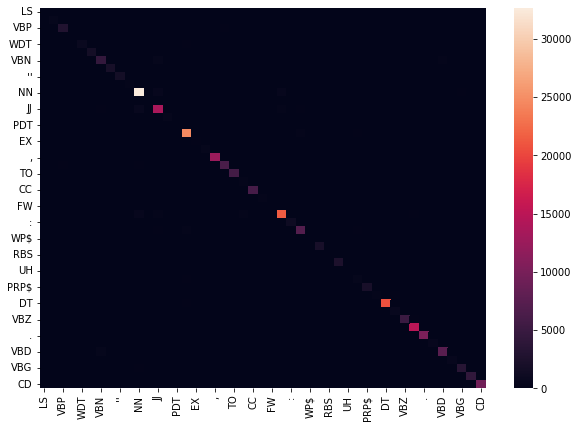

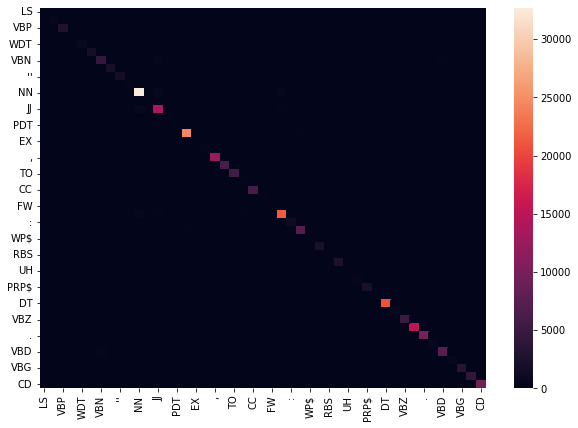

In [ ]:
print("--------------------")
evaluate(dev_data, pos_tagger, "trigram_beam_search", "laplace", beam_width = 2)
print("--------------------")
evaluate(dev_data, pos_tagger, "trigram_beam_search", "laplace", beam_width = 3)
print("--------------------")
evaluate(dev_data, pos_tagger, "trigram_beam_search", "laplace", beam_width = 5)

In [ ]:
def suboptial(k):
  result = []
  i = 0
  for sequence in dev_data[0]:
    result.append(pos_tagger.trigram_beam_search(sequence, "laplace", beam_width=k))
    i+=1
  data = dev_data
  sentences = data[0]
  tags = data[1]

  err = 0
  index = 0
  idx_list = []
  for sequence, pred, true in zip(sentences, result, tags):
    a = pos_tagger.snd_ord_sequence_probability(sequence, true)
    b = pos_tagger.snd_ord_sequence_probability(sequence, pred)
    if b < a:
      idx_list.append(index)
      err += 1
    index += 1

  return err

In [ ]:
print("k = 1:", suboptial(1))
print("k = 2:", suboptial(2))
print("k = 3:", suboptial(3))
print("k = 5:", suboptial(5))

k = 1: 141
k = 2: 92
k = 3: 60
k = 5: 48


In [ ]:
data = test_data
if data == test_data:
  print("# word:", len([w for words in data for w in words]))
  print("# documents:", len(data))
  print("# vocabulary:", len(set([w for words in data for w in words])))
  print("# tags: Unknown")
  print("# unknwon words:", len([w for words in data for w in words if w not in pos_tagger.word2idx]))
  print("# Unknown vocabulary:", len(set([w for words in data for w in words if w not in pos_tagger.word2idx])))
else:
  print("# word:", len([w for words in data[0] for w in words]))
  print("# documents:", len(data[0]))
  print("# vocabulary:", len(set([w for words in data[0] for w in words])))
  print("# tags:", len(set([t for tag in data[1] for t in tag])))
  print("# unknwon words:", len([w for words in data[0] for w in words if w not in pos_tagger.word2idx]))
  print("# Unknown vocabulary:", len(set([w for words in data[0] for w in words if w not in pos_tagger.word2idx])))



# word: 237045
# documents: 463
# vocabulary: 20180
# tags: Unknown
# unknwon words: 8233
# Unknown vocabulary: 6073


In [ ]:
word = "harmonious"
print("nious:", pos_tagger.suffix_matrix["nious"])
print("ious:", pos_tagger.suffix_matrix["ious"])
print("ous:", pos_tagger.suffix_matrix["ous"])
print("us:", pos_tagger.suffix_matrix["us"])
print("s:", pos_tagger.suffix_matrix["s"])

nious: {'JJ': 1}
ious: {'JJ': 438, 'JJR': 1, 'NNP': 19, 'NN': 1}
ous: {'JJ': 715, 'NNP': 28, 'RB': 1, 'NN': 3, 'JJR': 1}
us: {'PRP': 139, 'NNP': 158, 'NN': 191, 'CC': 37, 'JJ': 745, 'RB': 70, 'VB': 37, 'NNS': 3, 'VBP': 2, 'IN': 5, 'JJR': 1}
s: {'NNS': 42331, 'IN': 2974, 'VBZ': 16156, 'NNP': 4821, 'VBD': 2706, 'DT': 1729, 'NN': 2604, 'PRP$': 3960, 'POS': 6016, 'CD': 85, 'PRP': 247, 'RB': 958, 'JJ': 1093, 'RBR': 98, 'NNPS': 1912, 'CC': 58, 'JJR': 159, 'VB': 174, 'RP': 5, 'VBP': 36, 'FW': 16, 'UH': 12, 'JJS': 2, 'VBN': 1}


In [ ]:
result = []
i = 0
for sequence in dev_data[0]:
  result.append(pos_tagger.bigram_beam_search(sequence, None, beam_width=5))
  i+=1
data = dev_data
sentences = data[0]
tags = data[1]

err = 0
index = 0
idx_list = []
for sequence, pred, true in zip(sentences, result, tags):
  a = pos_tagger.snd_ord_sequence_probability(sequence, true)
  b = pos_tagger.snd_ord_sequence_probability(sequence, pred)
  if b < a:
    idx_list.append(index)
    err += 1
  index += 1

In [ ]:
len_list = [(i, len(dev_data[0][i])) for i in idx_list]
len_list.sort(key=lambda x:x[1])
len_list[:10]

[(94, 38),
 (352, 41),
 (385, 41),
 (167, 42),
 (299, 43),
 (321, 45),
 (378, 48),
 (159, 50),
 (40, 51),
 (37, 58)]

In [16]:
def error_analysis(index):
  sequence = dev_data[0][index]
  true = dev_data[1][index]
  # replace this line
  pred = pos_tagger.trigram_beam_search(sequence, "interpolation", beam_width=1)
  return [(sequence[i], true[i], pred[i]) for i in range(len(sequence)) if true[i] != pred[i]]

error_analysis(315)

[('Data', 'NNP', 'NNPS')]



```
pred = pos_tagger.trigram_viterbi(sequence, "laplace")
```

Capitalization: 41


NN, NNP confusion: 385



```
pred = pos_tagger.bigram_viterbi(sequence, "laplace")
```
NN, VBG confusion with ing as suffix: 94


NN, NNP confusion: 385



```
pred = pos_tagger.trigram_viterbi(sequence, "interpolation")
```

NN, VBG confusion with ing as suffix: 94


NN, NNP confusion: 385



```
pred = pos_tagger.trigram_viterbi(sequence, None)
```

(NN, VBG confusion with ing as suffix: 94) fixed in this model


(NN, NNP confusion: 385) persist


```
pred = pos_tagger.bigram_viterbi(sequence, None)
```
NN, VBG confusion with ing as suffix: 94


NN, NNP confusion: 385


```
pred = pos_tagger.trigram_beam_search(sequence, "laplace", beam_width=1)
```
Capitalization: 12


NN, VBG confusion with ing as suffix: 94


```
pred = pos_tagger.bigram_beam_search(sequence, "laplace", beam_width=1)
```
Capitalization: 12


NN, VBG confusion with ing as suffix: 94


```
pred = pos_tagger.trigram_beam_search(sequence, "interpolation", beam_width=1)
```
Capitalization: 315


```
pred = pos_tagger.trigram_beam_search(sequence, None, beam_width=1)
```
Capitalization: 12


NN, VBG confusion with ing as suffix: 94


```
pred = pos_tagger.bigram_beam_search(sequence, None, beam_width=1)
```
Capitalization: 12


NN, VBG confusion with ing as suffix: 94



```
pred = pos_tagger.trigram_beam_search(sequence, "laplace", beam_width=5)
```
Capitalization: 291


```
pred = pos_tagger.bigram_beam_search(sequence, "laplace", beam_width=5)
```
NN, VBG confusion with ing as suffix: 94


NN, NNP confusion: 385


```
pred = pos_tagger.trigram_beam_search(sequence, "interpolation", beam_width=5)
```
NN, VBG confusion with ing as suffix: 94


NN, NNP confusion: 385


```
pred = pos_tagger.trigram_beam_search(sequence, None, beam_width=5)
```
Capitalization: 291


```
pred = pos_tagger.bigram_beam_search(sequence, None, beam_width=5)
```
NN, VBG confusion with ing as suffix: 94


NN, NNP confusion: 385
